# imports

In [31]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch


import ColorDataUtils.mattplotlib as mplt
from ColorDataUtils.mattprintlib import fmt
from NDNT.utils import imagesc   # because I'm lazy

class Model:
    def __init__(self, ndn_model, LLs, trial):
        self.ndn = ndn_model
        self.LLs = LLs
        self.trial = trial
from models import iter_core, iter_0715_1x, iter_0722_1x, iter_0801_1x, iter_0808_1x, cnn_core, cnn_0715_1x, cnn_0722_1x, cnn_0801_1x, cnn_0808_1x

device = torch.device("cuda:1")

datadir = '/home/dbutts/ColorV1/Data/'
dirname = '/home/dbutts/ColorV1/CLRworkspace/'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# compare Iter model LLs for single and core

In [11]:
print('iter_core', iter_core.ndn_model.networks[-1].layers[-1].shape)
print('iter_0715_1x', iter_0715_1x.ndn_model.networks[-1].layers[-1].shape)
print('iter_0722_1x', iter_0722_1x.ndn_model.networks[-1].layers[-1].shape)
print('iter_0801_1x', iter_0801_1x.ndn_model.networks[-1].layers[-1].shape)
print('iter_0808_1x', iter_0808_1x.ndn_model.networks[-1].layers[-1].shape)
print('cnn_core', cnn_core.ndn_model.networks[-1].layers[-1].shape)

iter_core (1, 587)
iter_0715_1x (1, 174)
iter_0722_1x (1, 125)
iter_0801_1x (1, 148)
iter_0808_1x (1, 140)
cnn_core (1, 587)


In [12]:
print('Iter mean LLs:')
print()
print(fmt('name'), 
      fmt('core', col_width=10), 
      fmt('single', col_width=10))
print(fmt('expt J220715'), 
      fmt(np.mean(iter_core.LLs[:174+1]), col_width=10), 
      fmt(np.mean(iter_0715_1x.LLs), col_width=10))
print(fmt('expt J220722'), 
      fmt(np.mean(iter_core.LLs[174:174+125+1]), col_width=10), 
      fmt(np.mean(iter_0722_1x.LLs), col_width=10))
print(fmt('expt J220801'), 
      fmt(np.mean(iter_core.LLs[174+125:174+125+148+1]), col_width=10), 
      fmt(np.mean(iter_0801_1x.LLs), col_width=10))
print(fmt('expt J220808'), 
      fmt(np.mean(iter_core.LLs[174+125+148:]), col_width=10), 
      fmt(np.mean(iter_0808_1x.LLs), col_width=10))

Iter mean LLs:

name            core       single    
expt J220715    0.0284     0.0214    
expt J220722    0.0231     0.0111    
expt J220801    0.0384     0.0383    
expt J220808    0.0225     0.0186    


In [13]:
print('CNN mean LLs:')
print()
print(fmt('name'),
      fmt('cnn core', col_width=10),
      fmt('cnn single', col_width=10))
print(fmt('expt J220715'),
      fmt(np.mean(cnn_core.LLs[:174+1]), col_width=10),
      fmt(np.mean(cnn_0715_1x.LLs), col_width=10))
print(fmt('expt J220722'),
      fmt(np.mean(cnn_core.LLs[174:174+125+1]), col_width=10),
      fmt(np.mean(cnn_0722_1x.LLs), col_width=10))
print(fmt('expt J220801'),
      fmt(np.mean(cnn_core.LLs[174+125:174+125+148+1]), col_width=10),
      fmt(np.mean(cnn_0801_1x.LLs), col_width=10))
print(fmt('expt J220808'),
      fmt(np.mean(cnn_core.LLs[174+125+148:]), col_width=10),
      fmt(np.mean(cnn_0808_1x.LLs), col_width=10))

CNN mean LLs:

name            cnn core   cnn single
expt J220715    0.0268     0.0270    
expt J220722    0.0220     0.0173    
expt J220801    0.0390     0.0352    
expt J220808    0.0223     0.0182    


# STAs

## load the data

In [32]:
from ColorDataUtils.multidata_utils import MultiExperiment
num_lags=16
expt_names = ['J220715','J220722','J220801','J220808']
array_types = ['UT', 'UT', 'UT', 'UT']
expt_names = ['J220715']
array_types = ['UT']
expts = MultiExperiment(expt_names)
data, drift_terms, mu0s = expts.load(datadir,
                                     num_lags=num_lags,
                                     et_metric_thresh=0.8,
                                     array_types=array_types,
                                     luminance_only=True,
                                     build_stim=True)

  FILE_INFO: stim_locsLP list again -- ok but output check
167520 total time steps, 239 units
J220715 68.5% fixations remaining
  Stim expansion for shift: [900, 492, 1000, 592]
  Writing lam stim 0: overlap 60, 47
  Writing lam stim 1: overlap 60, 53
  Writing lam stim 2: overlap 33, 53
  Writing lam stim 3: overlap 33, 47
  Writing ETstim 0: overlap 7, 53
  Writing ETstim 1: overlap 7, 47
  Adding fixation point
  Shifting stim...


100%|█████████████████████████████████████████████████████████████████████████| 34/34 [00:13<00:00,  2.52it/s]


  CROP: New stim size: 60 x 60
  Done: expt 0
Stimulus assembly complete


## data STAs

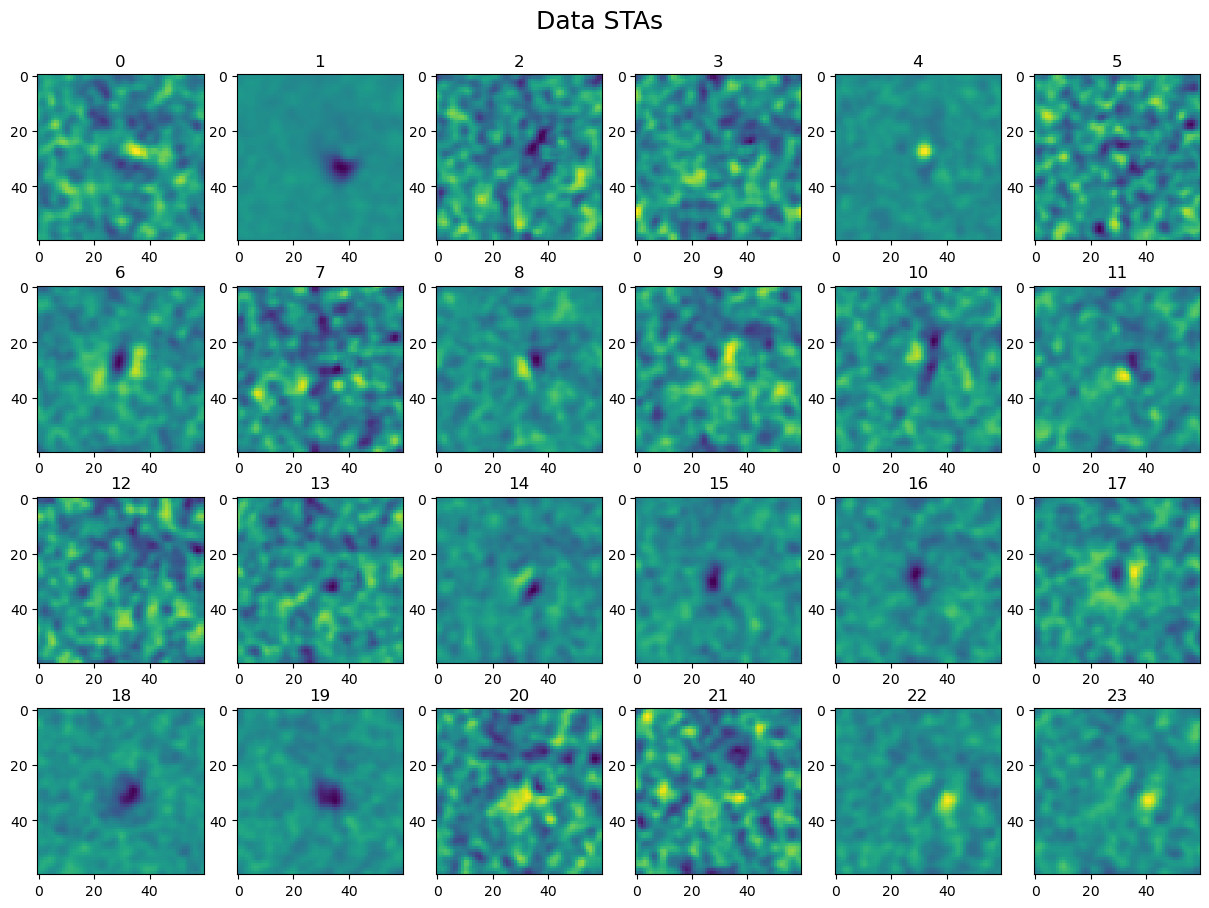

In [5]:
expts.check_STAs(title='Data STAs', device=device)

## pred STAs

In [37]:
cnn_0715_1x.ndn_model.to(device)
pred = cnn_0715_1x.ndn_model.generate_predictions(data, batch_size=2, device=device)

  0%|                                                                                 | 0/349 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████| 349/349 [01:44<00:00,  3.34it/s]


In [38]:
# save the npy pred to the iter_core model directory
np.save('../models/cnns_multi_08_1x_0715/pred.npy', pred.detach().cpu().numpy())
#pred = np.load('../models/cnns_multi_08/pred.npy')

/home/mattjac/projects/mattjac/v1/ColorDataUtils/mattplotlib.py:233: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  robs = torch.tensor(robs, dtype=torch.float32, device=device)


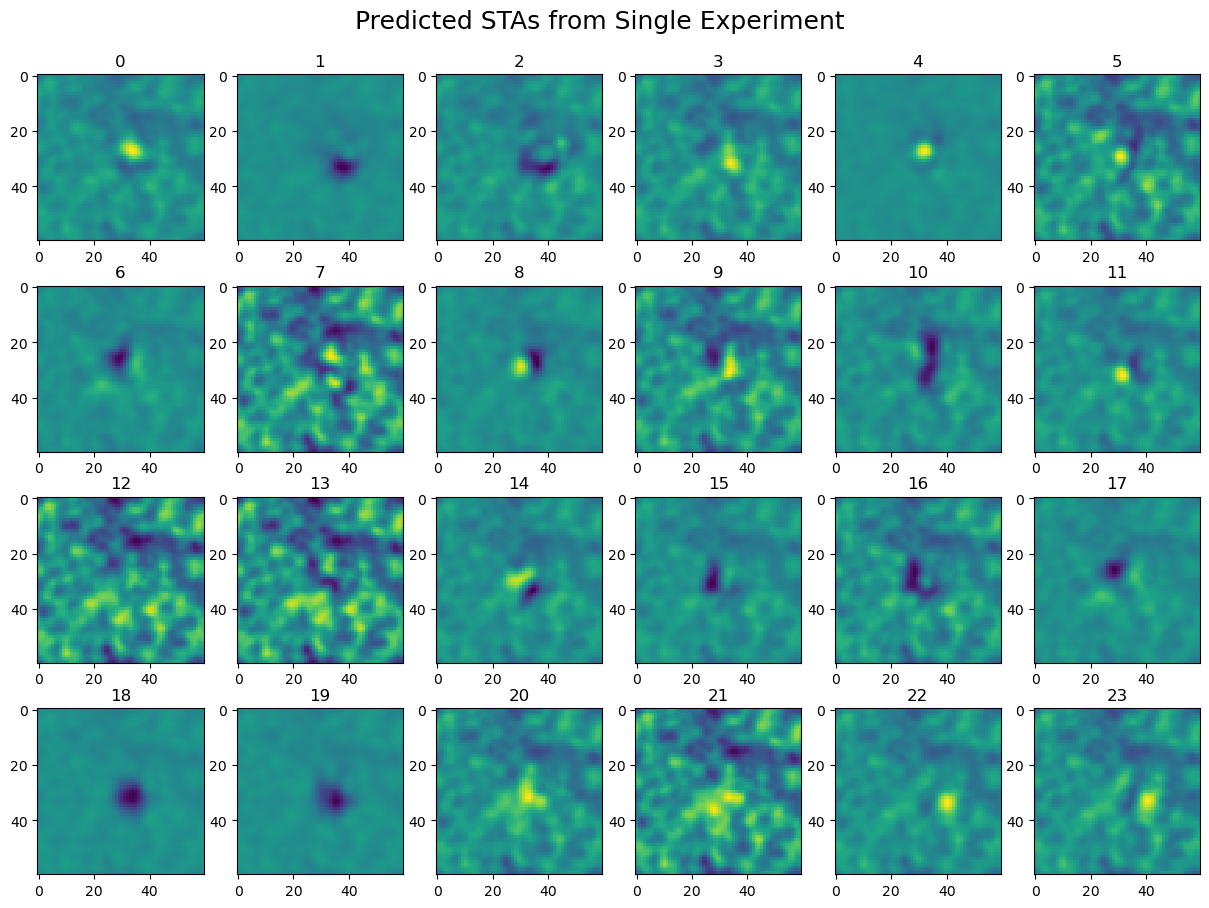

In [39]:
mplt.plot_stas(data, NX=expts.max_NX, lag=4, pred=pred, device=device, title='Predicted STAs from Single Experiment')